<a href="https://colab.research.google.com/github/hanan1988/ML_course_Pavia_23/blob/main/CD_ML_Ali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Circular dichroism (CD) is a spectroscopic technique used to study the optical properties of chiral molecules. Chiral molecules are those that are not superimposable on their mirror image, meaning they exist in two different forms called enantiomers. CD spectroscopy provides information about the structural and electronic properties of chiral molecules by measuring the difference in absorption of left-handed circularly polarized light (LCP) and right-handed circularly polarized light (RCP). 
The CD spectrum is obtained by measuring the differential absorption of LCP and RCP light as a function of the wavelength and it is defined by:
\begin{equation} CD(λ) = \frac{A_{lcp}- A_{rcp}}{A_{lcp}+A_{rcp}}\end{equation}
Where $A_{\rm lcp}$ and $A_{\rm rcp}$ are the absorption of left and right circular polarized light. 

The resulting spectrum displays positive and negative bands that correspond to electronic transitions in the molecule. The intensity and shape of these bands can provide insights into the conformation, chirality, secondary structure (e.g., protein folding), and interactions of the molecule under investigation.

In this notebook, we applied DNN to reproduce CD signal of Fig.6 of our recent published results in Optics Express (https://doi.org/10.1364/OE.485324). 

In the figure below, we show a simple sketch of the metasurface with tilted elliptic nanohole used to produce the CD signal. A metal layer of thickness (h) is embedded between glass substrate (SiO2) and air. $R_{\rm1}$ ($D_{\rm1}$/2), $R_{\rm2}$ ($D_{\rm2}$/2) are the radii of the nano ellipse. In our published paper we studied the CD signal as a function of the nano ellipse radius $R_{\rm1}$, where we kept $R_{\rm2}$ fixed. In this notebook we tried to reproduce this result which is shown in the map below.

In our case, we have a dataset with two featuers which are the radius $R_{\rm1}$ and wavelength (λ), and the target is CD signal. 

In the following I show how I applied NN on our simulation dataset. It is worth mentioning that our problem is a regression problem. 
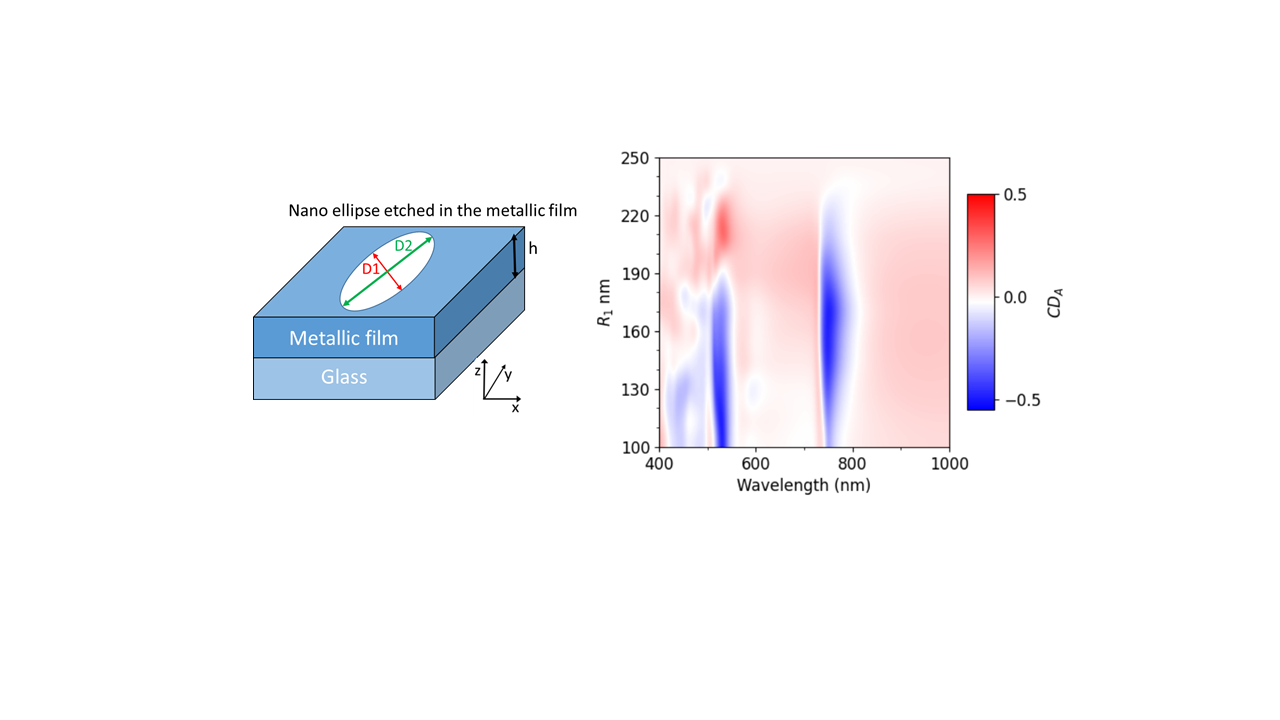
 

In [3]:
#Step 1: Import related libraries

import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [4]:
#Step 2 : Mount google drive and load the dataset file
from google.colab import drive
drive.mount('/content/drive')

dataset = '/content/drive/MyDrive/fdtd_cd_map_r1_tilted.txt'  
print(dataset) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/fdtd_cd_map_r1_tilted.txt


Our dataset file is made of blocks separated by an empty line because we want a map of circular dichroism as a function of the short radius of the nano ellipse, as we see from the map, CD signal increases with increased R1.

In [5]:
#Step 3: Read the data file: if you do not mind I had to use this function in order to read the dataset file

def read_myfile(f):
    """ reads all columns from a data file made of blocks separated by blank lines"""

    print('entering read_myfile, f=', f)
    x, x_array = [], []    # x is the temporary list that contains each block, x_array is the full list of all blocks

    icount=0
    for line in f:
        line=re.sub("^\s+","",line).rstrip()
        values = [s for s in line.split()]
        if line != '':        # starts reading a block if the line is not empty
            if values[0] != "#" and values[0] != "lambda" and values[0] != "nm": # if we are not in the header...
                ncol = np.shape(values)[0]     # ... we read the number of columns...
                row = []                       # ... and put the line in the list "row"
                for j in range(ncol):
                    row.append(float(values[j]))
                x.append(row)

        else:      #empty line separating different blocks
            #if (icount >= 0): print('read data for icount, x[1]=',icount,x[2][0])
            icount=icount+1
            if ncol != 0:
                x_array.append(x)  # save temporary list in final list

                x = []         # re-initialize temporary list

    x_array=np.asarray(x_array)   # this array has shape (n1, n2) where n1 is the number of rows in each block and n2 is the number of columns
    print('shape(x_array)=',np.shape(x_array))
    print('exiting read_myfile')

    return x_array, ncol

entering read_myfile, f= <_io.TextIOWrapper name='/content/drive/MyDrive/fdtd_cd_map_r1_tilted.txt' mode='r' encoding='UTF-8'>
shape(x_array)= (16, 301, 17)
exiting read_myfile
shape of x= (16, 301, 17)
nr1, nlambda= 16 301
shape of Lambda= (301,)
shape of cd= (16, 301)
extent= (400.0, 1000.0, 100.0, 250.0)


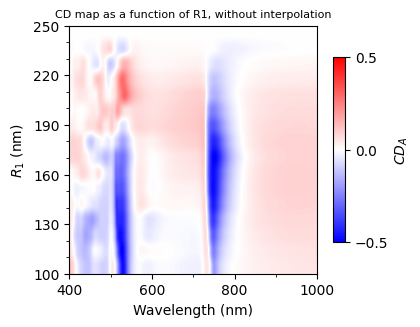

In [31]:
#Step 4: In this step I wanted to plot the figure showed previously after reading the file

def plot_map(Lambda, R1, A_cd, vmin, vmax, xlabel, ylabel, xticks, yticks, cmap='bwr'):

  ticksfontsize = 10
  labelfontsize = 10
  colorbarfontsize = 10
  titlefontsize = 8
  location='right'

  aspect = (xmax-xmin)/(ymax-ymin)
  extent = xmin, xmax, ymin, ymax
  print('extent=',extent)

  fig = plt.figure(figsize=(4,4), constrained_layout=False)
  ax0 = fig.add_subplot(111)

  ##plot cd as a function of radius (R1) ##
  ax0.set_title('CD map as a function of R1, without interpolation', size = titlefontsize )
  f0=ax0.imshow(A_cd, origin="lower", extent=extent, vmin=vmin, vmax=vmax, cmap=cmap, interpolation = None)
  ax0.set_aspect(aspect)
  ax0.set_xlim([xmin, xmax])
  ax0.set_xticks(xticks)
  ax0.set_xlabel(xlabel, fontsize=labelfontsize)
  ax0.set_ylim([ymin, ymax])
  ax0.set_ylabel(ylabel, fontsize=labelfontsize)
  ax0.set_yticks(yticks)
  ax0.tick_params(labelcolor='black', labelsize=ticksfontsize)
  ax0.xaxis.set_minor_locator(MultipleLocator(100)) 
  ax0.yaxis.set_minor_locator(MultipleLocator(10))  
  cb=fig.colorbar(f0, ax=ax0, shrink=0.6, aspect=15, location=location)
  cb.set_label(label=label, size=colorbarfontsize)
  cb.set_ticks(ticks=np.linspace(vmin, vmax, 3))
  cb.ax.tick_params(labelsize=ticksfontsize)
  ##End ##
filename = 'fdtd_cd_map_r1_tilted.txt'
f = open(dataset,'r')    # file to read the data
x, ncol = read_myfile(f)
f.close()
print("shape of x=", np.shape(x))
nr1, nlambda = np.shape(x)[0], np.shape(x)[1]
print('nr1, nlambda=', nr1, nlambda)
Lambda, R1, A_cd  = x[0,:,0], x[:,0,1], x[:,:,10]
print("shape of Lambda=", np.shape(Lambda))
print("shape of cd=", np.shape(A_cd))

xmin, xmax = Lambda[0], Lambda[-1]
ymin, ymax = R1[0], R1[-1]
nx, ny = 4, 6
xticks  = np.linspace(xmin, xmax, nx)
yticks  = np.linspace(ymin, ymax, ny)
vmin, vmax, label = -0.5, 0.5, r'$CD_{A}$'
xlabel, ylabel = r'Wavelength (nm)', '$R_{1}$ (nm)'
plot_map(Lambda, R1, A_cd, vmin, vmax, xlabel, ylabel, xticks, yticks, cmap='bwr')

In [7]:
#Step 5: Define features and target 

ndata = nr1 * nlambda
print(ndata)

CD = np.zeros([ndata])
combined_array = np.zeros([ndata, 2])

ind = 0
for j1 in range(nr1):
  for j2 in range(nlambda):

    combined_array[ind, 0] = R1[j1]
    combined_array[ind, 1] = Lambda[j2]
    
    CD[ind] = A_cd[j1,j2]
    ind = ind+1

target = CD
print("shape of target=", target.shape, target)

features = combined_array
print("shape of features=", features.shape, features)

4816
shape of target= (4816,) [ 1.35167e-01  1.24325e-01  1.12679e-01 ... -6.37502e-08 -6.12384e-08
 -6.01737e-08]
shape of features= (4816, 2) [[ 100.  400.]
 [ 100.  402.]
 [ 100.  404.]
 ...
 [ 250.  996.]
 [ 250.  998.]
 [ 250. 1000.]]


In [8]:
#Step 6: Split the dataset into training and testing sets where 
""" I chose 50% of the data to be used for testing, and the remaining 50% will be used for training the model."""

X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.5, random_state = 42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
#print("X_train=", X_train)
#print("Y_train=", y_train)
#print("X_val=", X_val)
#print("y_val=", y_val)

(2408, 2) (2408, 2) (2408,) (2408,)


In [9]:
#Step 7: Normalizing the data 

from sklearn import preprocessing

# fit data
scaler = preprocessing.StandardScaler().fit(X_train)
# scaling data
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [10]:
#Step 8: Building the neural network 
""" The resulting spectrum displays positive and negative bands in the 
    interval [-1 1], I had to use tanh activation function on the output layer 
    but for the hidden layers I used relu activation function."""

input_shape = X_train.shape[1]
#  this list of layer was chosen after I tried many layers with different 
#  number of neurons, and this NN worked for my data 

layer_list = [4,10,32,64,32,10,4,2] 
act = 'relu'
act1 = 'tanh'

model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(layer_list[0], input_shape=(input_shape,),activation=act))
for layer in layer_list[1:]:
  model.add(tf.keras.layers.Dense(layer,activation=act))
model.add(tf.keras.layers.Dense(1,activation=act1))

In [19]:
#Step 9: Compile the model

model.compile(loss='mean_squared_error', optimizer= Adam(lr = 1e-3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 10)                50        
                                                                 
 dense_2 (Dense)             (None, 32)                352       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
 dense_6 (Dense)             (None, 4)                 4

In [20]:
#Step 10: Train the model

batch_size = 150
n_epochs = 300  # choose this value for a quick calculation (only main two peaks are reproduced)
#n_epochs = 5000 # choose this value for a precise calculation, but much slower 

history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = batch_size, 
                    verbose=1, validation_data = (X_val, y_val))

Epoch 1/300
17/17 [==============================] - 4s 24ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/300
17/17 [==============================] - 0s 13ms/step - loss: 6.4592e-04 - val_loss: 5.4428e-04
Epoch 3/300
17/17 [==============================] - 0s 11ms/step - loss: 4.8562e-04 - val_loss: 5.1563e-04
Epoch 4/300
17/17 [==============================] - 0s 12ms/step - loss: 4.5144e-04 - val_loss: 5.0365e-04
Epoch 5/300
17/17 [==============================] - 0s 12ms/step - loss: 4.7579e-04 - val_loss: 4.7544e-04
Epoch 6/300
17/17 [==============================] - 0s 9ms/step - loss: 4.3960e-04 - val_loss: 5.1198e-04
Epoch 7/300
17/17 [==============================] - 0s 8ms/step - loss: 4.7204e-04 - val_loss: 6.7219e-04
Epoch 8/300
17/17 [==============================] - 0s 9ms/step - loss: 5.0511e-04 - val_loss: 5.6158e-04
Epoch 9/300
17/17 [==============================] - 0s 8ms/step - loss: 4.8090e-04 - val_loss: 5.0355e-04
Epoch 10/300
17/17 [====================

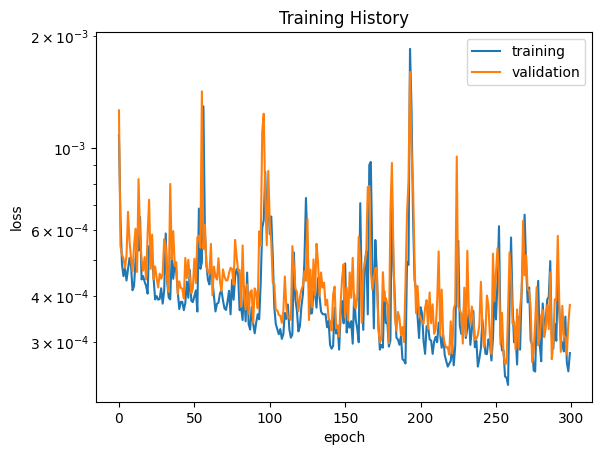

In [21]:
#Step 11:  plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [22]:
#Step 12: Evaluate the model
#☻ prediction on the validation set
y_pred = model.predict(scaler.transform(X_val)) # predicted values CD after the training
#print(y_pred)

# Calculate the root mean squared deviation (RMSD)
mse = mean_squared_error(y_val, y_pred)
n_val = y_val.shape[0]
print("n_val=", n_val)

rmsd = np.sqrt(mse)

for j in range (n_val):

  if ((j//100)*100 == j): print(X_val[j,0],X_val[j,1], y_val[j], y_pred[j][0], \
       y_val[j]-y_pred[j][0])

print("Average=", np.sum(y_val)/len(y_val))
print("Mean Squared Error:", mse)
print('Root Mean Squared Deviation:', rmsd)

print("shape of y_pred=", y_pred.shape)
print("X_val, y_val =", X_val.shape, y_val.shape)

76/76 [==============================] - 0s 2ms/step
n_val= 2408
-0.3415684688309136 0.41960624220795445 -0.266908 0.6022051 -0.8691130976753234
0.971625048377452 -0.13380401246883158 0.0514727 0.6026806 -0.5512079235313415
-0.5604340550323078 -0.7563905489802158 0.0439626 0.6032713 -0.5593087055610657
-1.6547619860392793 -1.2290951415166371 -0.091576 0.6037182 -0.6952942211875915
0.7527594621760578 1.6763086955364894 0.0604574 0.60104674 -0.5405893410087586
0.971625048377452 -1.1829776202935718 -0.031815 0.60362756 -0.6354425625228882
-0.9981652274350964 0.869252074132843 0.0487172 0.60181046 -0.5530932553222656
-0.9981652274350964 -0.6756848868398512 -0.0346066 0.60320693 -0.6378135325447083
1.6282218069816348 0.40807686190218806 1.90945e-08 0.6021784 -0.6021783756999641
1.1904906345788464 0.25819491792722515 -0.0455254 0.6023221 -0.6478475015930176
-0.9981652274350964 -1.067683817235908 -0.388914 0.60356075 -0.992474745716095
-1.4358963998378849 -1.0446250566243753 -0.33676 0.603547

(4816, 2)
151/151 [==============================] - 0s 3ms/step
extent= (400.0, 1000.0, 100.0, 250.0)
shape of A_cd: shape of pred_cd: (16, 301) (16, 301)


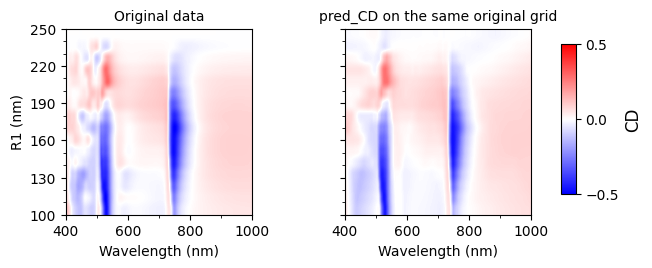

In [25]:
# prediction on a full rectangular grid, in order to compare with the original plot

# definition of the array of shape (nr1*nlambda,2) 
r1_lambda_array = []
index = 0
for j1 in range(nr1):
  for j2 in range(nlambda):
    r1_lambda_array.append([R1[j1], Lambda[j2]])
    index = index+1 
print(np.shape(r1_lambda_array))

# predict values on the full grid
y_pred_array = model.predict(scaler.transform(r1_lambda_array))

# define a grid of shape (nr1, nlambda) for plotting
y_pred_grid = np.zeros([nr1,nlambda])
index = 0
for j1 in range(nr1):
  for j2 in range(nlambda):
    y_pred_grid[j1,j2] = y_pred_array[index]
    index = index+1
    
# let us plot the results
r1min, r1max, lambdamin, lambdamax = R1[0], R1[-1], Lambda[0], Lambda[-1]
extent = lambdamin, lambdamax, r1min, r1max
aspect = (lambdamax-lambdamin)/(r1max-r1min)
print('extent=',extent)
cmap = 'bwr'
vmin, vmax = -0.5, 0.5
nx, ny = 4, 6
xticks  = np.linspace(lambdamin, lambdamax, nx)
yticks  = np.linspace(r1min, r1max, ny)

print("shape of A_cd:","shape of pred_cd:", np.shape(A_cd), np.shape(y_pred_grid))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,5), sharey=True)
plt.subplots_adjust(wspace= 0.5)
ax1.set_title("Original data", size = 10)
f0 = ax1.imshow(A_cd, extent=extent, vmin=vmin, vmax=vmax, origin="lower", cmap=cmap, interpolation = None)
ax1.set_aspect(aspect)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_xlim(Lambda[0], Lambda[-1])
ax1.set_xticks(xticks)
ax1.set_ylabel('R1 (nm)')
ax1.set_ylim(R1[0], R1[-1])
ax1.set_yticks(yticks)
ax1.xaxis.set_minor_locator(MultipleLocator(100)) 
ax1.yaxis.set_minor_locator(MultipleLocator(10))  

ax2.set_title("pred_CD on the same original grid", size = 10)
f0 = ax2.imshow(y_pred_grid, extent=extent, vmin=vmin, vmax=vmax, origin="lower", cmap=cmap)
ax2.set_aspect(aspect)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim(Lambda[0], Lambda[-1])
ax2.set_xticks(xticks)
ax2.xaxis.set_minor_locator(MultipleLocator(100)) 
ax2.yaxis.set_minor_locator(MultipleLocator(10))  

cb   = fig.add_axes([0.95, 0.35, 0.025, 0.3])
cbar = fig.colorbar(f0, cb)
cbar.set_label('CD', size=12)
cbar.set_ticks(ticks=np.linspace(vmin, vmax, 3))

In this part we want to use the NN to predict new results of CD on a dense grid. Since the original calculations done in FDTD are time consuming, we can use instead the NN. 
We can see that the NN is working as an interpolation technique. 

(18631, 2)
583/583 [==============================] - 1s 2ms/step
extent= (400.0, 1000.0, 100.0, 250.0)
shape of A_cd: shape of pred_cd: (16, 301) (31, 601)


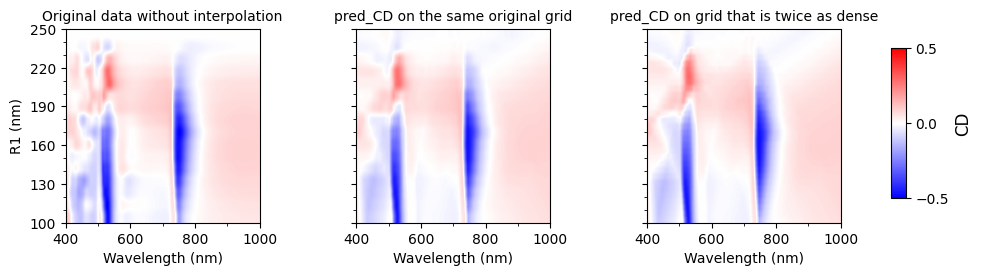

In [28]:
# prediction on a full rectangular grid that is twice as dense

# definition of new numbers of points
nrr1 = 2*nr1-1
nllambda = 2*nlambda-1

# definition of new arrays that are twice as dense
RR1 = np.linspace(R1[0], R1[-1], nrr1)
#print(RR1)
LLambda = np.linspace(Lambda[0], Lambda[-1], nllambda)
#print(LLambda)

# definition of the array of shape (nrr1*nllambda, 2) 
rr1_llambda_array = []
index = 0
for j1 in range(nrr1):
  for j2 in range(nllambda):
    rr1_llambda_array.append([RR1[j1], LLambda[j2]])
    index = index+1 
print(np.shape(rr1_llambda_array))

# predict values on the full grid
yy_pred_array = model.predict(scaler.transform(rr1_llambda_array))

# define a grid of shape (nnr1, nnlambda) for plotting
yy_pred_grid = np.zeros([nrr1,nllambda])
index = 0
for j1 in range(nrr1):
  for j2 in range(nllambda):
    yy_pred_grid[j1,j2] = yy_pred_array[index]
    index = index+1
    
# let us plot the results
r1min, r1max, lambdamin, lambdamax = R1[0], R1[-1], Lambda[0], Lambda[-1]
extent = lambdamin, lambdamax, r1min, r1max
aspect = (lambdamax-lambdamin)/(r1max-r1min)
print('extent=',extent)
cmap = 'bwr'
vmin, vmax = -0.5, 0.5

print("shape of A_cd:","shape of pred_cd:", np.shape(A_cd), np.shape(yy_pred_grid))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5), sharey=True)
plt.subplots_adjust(wspace= 0.5)
ax1.set_title("Original data without interpolation", size = 10)
f0 = ax1.imshow(A_cd, extent=extent, vmin=vmin, vmax=vmax, origin="lower", cmap=cmap)
ax1.set_aspect(aspect)
ax1.set_xlabel('Wavelength (nm)')
ax1.set_xlim(Lambda[0], Lambda[-1])
ax1.set_xticks(xticks)
ax1.set_ylabel('R1 (nm)')
ax1.set_ylim(R1[0], R1[-1])
ax1.set_yticks(yticks)
ax1.xaxis.set_minor_locator(MultipleLocator(100)) 
ax1.yaxis.set_minor_locator(MultipleLocator(10))  

ax2.set_title("pred_CD on the same original grid", size = 10)
f0 = ax2.imshow(y_pred_grid, extent=extent, vmin=vmin, vmax=vmax, origin="lower", cmap=cmap, interpolation = None)
ax2.set_aspect(aspect)
ax2.set_xlabel('Wavelength (nm)')
ax2.set_xlim(Lambda[0], Lambda[-1])
ax2.set_xticks(xticks)
ax2.set_ylim(R1[0], R1[-1])
ax2.set_yticks(yticks)
ax2.xaxis.set_minor_locator(MultipleLocator(100)) 
ax2.yaxis.set_minor_locator(MultipleLocator(10))  

ax3.set_title("pred_CD on grid that is twice as dense", size = 10)
f0 = ax3.imshow(yy_pred_grid, extent=extent, vmin=vmin, vmax=vmax, origin="lower", cmap=cmap)
ax3.set_aspect(aspect)
ax3.set_xlabel('Wavelength (nm)')
ax3.set_xlim(Lambda[0], Lambda[-1])
ax3.set_xticks(xticks)
ax3.set_ylim(R1[0], R1[-1])
ax3.set_yticks(yticks)
ax3.xaxis.set_minor_locator(MultipleLocator(100)) 
ax3.yaxis.set_minor_locator(MultipleLocator(10))  

cb   = fig.add_axes([0.95, 0.35, 0.015, 0.3])
cbar = fig.colorbar(f0, cb)
cbar.set_label('CD', size=12)
cbar.set_ticks(ticks=np.linspace(vmin, vmax, 3))